In [1]:
import cv2
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
modelsDir = 'NeuralNetwork'
dataDir = 'data'
def plotPrint(history):

    epochs = np.arange(len(history.history['val_loss'])) + 1
    fig = plt.figure(figsize=(8, 4))
    if 'accuracy' in history.history:
        ax1 = fig.add_subplot(121)
        ax1.plot(epochs, history.history['loss'], c='b', label='Train loss')
        ax1.plot(epochs, history.history['val_loss'], c='g', label='Valid loss')
        plt.legend(loc='lower left');
        plt.grid(True)

        ax1 = fig.add_subplot(122)
        ax1.plot(epochs, history.history['accuracy'], c='b', label='Train acc')
        ax1.plot(epochs, history.history['val_accuracy'], c='g', label='Valid acc')
        plt.legend(loc='lower right');
        plt.grid(True)


    else:
        ax1 = fig.add_subplot(111)
        ax1.plot(epochs, history.history['loss'], c='b', label='Train loss')
        ax1.plot(epochs, history.history['val_loss'], c='g', label='Valid loss')
        plt.legend(loc='lower left');
        plt.grid(True)
    plt.show()

# def loadModel(c):
#     print("loadModel")
#     f = open(f"{modelsDir}/last.txt", "r")
#     name = f.readline()
#     print(f'model name: {name}')
#     f.close()
#     model = load_model(f'{modelsDir}/{name}/model.h5')
#     options = ['l', 't', 'q']
#     print(f"{options[0]} - loadWeights\n"
#           f"{options[1]} - trainModel\n"
#           f"{options[2]} - guit\n")
#     x = getInput(options,c)
#     if x == options[0]:
#         model.load_weights(f'{modelsDir}/{name}/weights.h5')
#     elif x == options[2]:
#         exit(0)
#     return model

# def saveModel(model):
#     dir = f'{modelsDir}'
#     if not os.path.exists(dir):
#         os.makedirs(dir)
#     name = runDataTime.strftime("%Y-%m-%d_%H_%M")
#     print(f'Save model: {name}')
#     model.save(f'{modelsDir}/{name}/model.h5')
#     model.save_weights(f'{modelsDir}/{name}/weights.h5')
#     f = open(f'{modelsDir}/last.txt', "w")
#     f.write(name)
#     f.close()

def saveModel(model, model_name):
    dir = f'{modelsDir}/{model_name}'
    if not os.path.exists(dir):
        os.makedirs(dir)
    model.save(f'{modelsDir}/{model_name}/model.h5')
    print(f"Model został zapisany pod nazwą: {model_name}")

def loadModel(model_name):
    loaded_model = tf.keras.models.load_model(f'{modelsDir}/{model_name}/model.h5')
    print(f"Model został wczytany z pliku: {model_name}")
    return loaded_model

def loadImage(imageDir, new=True):
    if (new): 
        csv_file = f'{dataDir}/new_stanford_cars_type.csv'
    else:
        csv_file = f'{dataDir}/stanford_cars_type.csv'

    img_folder = f'{dataDir}/{imageDir}'
    data_csv = pd.read_csv(csv_file)
    images_tab = []
    labels_string = []

    for index, row in data_csv.iterrows():
        filename = row['file_name']
        category = row['car_type']

        image_path = os.path.join(img_folder, filename)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        images_tab.append(image)
        labels_string.append(category)
    images = np.array(images_tab)
    return (images,labels_string)

def encodeLabel(labels_s):
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels_s)
    return (labels_encoded, label_encoder)


def preprocessImages(images):
    preprocessed_images = []

    for image in images:
        if image is not None: 
            equalized_image = cv2.equalizeHist(np.uint8(image))
            normalized_image = equalized_image / 255.0
            preprocessed_images.append(normalized_image)
    preprocessed_images = np.array(preprocessed_images)
    return preprocessed_images

def resizeAndSaveImages(input_folder, output_folder, target_size=(255, 255)):
    output_folder = f'{dataDir}/{output_folder}'
    input_folder = f'{dataDir}/{input_folder}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.jpg'):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            resized_image = cv2.resize(image, target_size)
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, resized_image)


def generateFromOriginalImages(outputFlder, newSize=(256,256)):
    main_data_folder = f'{dataDir}/stanford_cars_type'

    output_folder = f'{dataDir}/{outputFlder}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for label in os.listdir(main_data_folder):
        label_folder = os.path.join(main_data_folder, label)
        
        for image_file in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_file)

            # Wyodrębnij tylko cyfry z początku nazwy
            numeric_prefix = re.match(r'^\d+', image_file).group()

            # Wczytaj obraz za pomocą OpenCV
            image = cv2.imread(image_path)

            # Przeskaluj obraz do nowego wymiaru (255x255) i zamień na skalę szarości
            image = cv2.resize(image, newSize)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Nazwa nowego pliku
            new_filename = f'{numeric_prefix}.jpg'
            new_image_path = os.path.join(output_folder, new_filename)

            # Zapisz przetworzony obraz
            cv2.imwrite(new_image_path, image)
            
def splitData(images,labels_encoded):
    imagesData = images.reshape(images.shape + (1,))
    X_train, X_test, y_train, y_test = train_test_split(imagesData, labels_encoded, test_size=0.2, random_state=1, stratify=labels_encoded)
    return (X_train, X_test, y_train, y_test)



def labelsPlot(labels_string):
    # Zliczenie etykiet
    label_counts = Counter(labels_string)

    print(label_counts)

    # Rozpakowanie nazw etykiet i ich liczności do wykresu słupkowego
    labels, counts = zip(*label_counts.items())

    # Generowanie wykresu słupkowego
    plt.figure(figsize=(8, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Klasy etykiet')
    plt.ylabel('Liczba obrazów')
    plt.title('Rozkład klas etykiet')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()






# def generate_image_histogram_by_index(images_data, labels, index, bins=256):
#     # Sprawdzenie poprawności indeksu
#     if index < 0 or index >= len(images_data):
#         print("Nieprawidłowy indeks")
#         return

#     print("images len = ", len(images_data))

#     # Wybranie obrazu na podstawie indeksu
#     image = images_data[index].reshape(255,255)
  
#     # Wyświetlenie obrazu i jego histogramu
#     plt.figure(figsize=(8, 4))

#     plt.subplot(1, 2, 1)
#     plt.imshow(image, cmap='gray')
#     plt.title(f'Wybrane zdjęcie: {index}')
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     plt.hist(image.ravel(),100,[0,255])
#     plt.title('Histogram wybranego zdjęcia')
#     plt.xlabel('Wartość piksela')
#     plt.ylabel('Liczba pikseli')
#     plt.grid()

#     plt.tight_layout()
#     plt.show()

def generate_image_histogram_by_index(images_data, labels, index, bins=256):
    # Sprawdzenie poprawności indeksu
    if index < 0 or index >= len(images_data):
        print("Nieprawidłowy indeks")
        return
    image = images_data[index]
    max_value = np.max(image)
    if not(max_value > 1):
        image = image * 255.0
    height, width = image.shape[:2]

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Wybrane zdjęcie: {index}\nRozmiar: {width}x{height}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.hist(image.ravel(), bins, [0, 255])
    plt.title(f'Histogram wybranego zdjęcia {labels[index]}')
    plt.xlabel('Wartość piksela')
    plt.ylabel('Liczba pikseli')
    plt.grid()


    plt.tight_layout()
    plt.show()

def showImage:
index_to_display = 2137  # Możesz zmienić indeks, aby wyświetlić inny obraz

# Wyświetlenie wybranego obrazu
plt.imshow(images[index_to_display], cmap='gray')  # 'gray' oznacza, że obraz będzie wyświetlony w skali szarości
plt.axis('off')  # Wyłączenie osi
plt.title(f"Obraz {index_to_display}")
plt.show()


In [2]:
main_data_folder = 'data/stanford_cars_type'

images = []
labels = []
name = []

for label in os.listdir(main_data_folder):
    label_folder = os.path.join(main_data_folder, label)
    
    for image_file in os.listdir(label_folder):
        image_path = os.path.join(label_folder, image_file)
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Opcjonalne: Zmiana kanałów kolorów

        images.append(image)
        labels.append(label)
        name.append(image_file)
    


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)


In [7]:
print(f'{labels_encoded.size}   {len(images)}')
np_images = np.array(images)
print(f'{labels_encoded.T.shape}   {np_images.T.shape}')

concatenated_array = np.vstack((labels_encoded, np_images)).T
print(f'{concatenated_array.shape}')


8144   8144


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (8144,) + inhomogeneous part.

In [3]:
main_data_folder = 'data/stanford_cars_type'

# Ścieżka do folderu, w którym zostaną zapisane przetworzone zdjęcia
output_folder = 'data/processed'

# Nowy wymiar obrazu
new_size = (255, 255)

# Przetwarzanie i zapis przetworzonych zdjęć
for label in os.listdir(main_data_folder):
    label_folder = os.path.join(main_data_folder, label)
    
    for image_file in os.listdir(label_folder):
        image_path = os.path.join(label_folder, image_file)

        # Wyodrębnij tylko cyfry z początku nazwy
        numeric_prefix = re.match(r'^\d+', image_file).group()

        # Wczytaj obraz za pomocą OpenCV
        image = cv2.imread(image_path)

        # Przeskaluj obraz do nowego wymiaru (255x255) i zamień na skalę szarości
        image = cv2.resize(image, new_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Nazwa nowego pliku
        new_filename = f'{numeric_prefix}.jpg'
        new_image_path = os.path.join(output_folder, new_filename)

        # Zapisz przetworzony obraz
        cv2.imwrite(new_image_path, image)

In [6]:
csv_file = 'data/stanford_cars_type.csv'
img_folder = 'data/processed'
data_csv = pd.read_csv(csv_file)
images_tab = []
labels_string = []

for index, row in data_csv.iterrows():
    filename = row['file_name']
    category = row['car_type']

    image_path = os.path.join(img_folder, filename)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = image / 255.0
    images_tab.append(image)
    labels_string.append(category)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_string)
images = np.array(images_tab)

In [44]:
print(f'{labels_encoded.shape}   {images.shape}')
print(labels_string)

(8144,)   (8144, 255, 255)
['Coupe', 'Sedan', 'Cab', 'Sedan', 'Cab', 'Convertible', 'SUV', 'Sedan', 'Sedan', 'SUV', 'Sedan', 'SUV', 'Sedan', 'Minivan', 'Hatchback', 'Coupe', 'Coupe', 'Sedan', 'Hatchback', 'Other', 'Other', 'Convertible', 'SUV', 'Hatchback', 'Sedan', 'Sedan', 'Sedan', 'Cab', 'Coupe', 'Sedan', 'SUV', 'Hatchback', 'Other', 'SUV', 'SUV', 'Coupe', 'Convertible', 'Other', 'Sedan', 'SUV', 'Coupe', 'Hatchback', 'Van', 'Convertible', 'SUV', 'Coupe', 'Sedan', 'Sedan', 'Sedan', 'Coupe', 'Cab', 'SUV', 'Coupe', 'Other', 'Coupe', 'Cab', 'Sedan', 'Cab', 'Cab', 'Cab', 'Cab', 'Hatchback', 'Coupe', 'Sedan', 'Convertible', 'Sedan', 'Other', 'Cab', 'Sedan', 'Sedan', 'Minivan', 'SUV', 'Cab', 'Cab', 'Sedan', 'Convertible', 'SUV', 'Coupe', 'SUV', 'Other', 'Convertible', 'Hatchback', 'Wagon', 'Wagon', 'Sedan', 'SUV', 'Sedan', 'Hatchback', 'Sedan', 'Cab', 'Sedan', 'Sedan', 'Convertible', 'Coupe', 'Cab', 'Coupe', 'Other', 'Sedan', 'SUV', 'Van', 'Hatchback', 'Sedan', 'Sedan', 'Cab', 'SUV', 'Seda

### Eksploracyjna analiza danych
Przed wygenerowaniem wykresu należy uruchomić poprzednią komórkę, która zawiera przetworzone obrazy
- Wykres przedstawiający rozkład klas etykiet
- Możliwość wyświetlenia dowolnego obrazu ze zbioru danych wraz z histogramem

Counter({'Sedan': 1907, 'SUV': 1437, 'Coupe': 1088, 'Convertible': 1036, 'Cab': 719, 'Other': 609, 'Hatchback': 554, 'Wagon': 291, 'Van': 253, 'Minivan': 250})


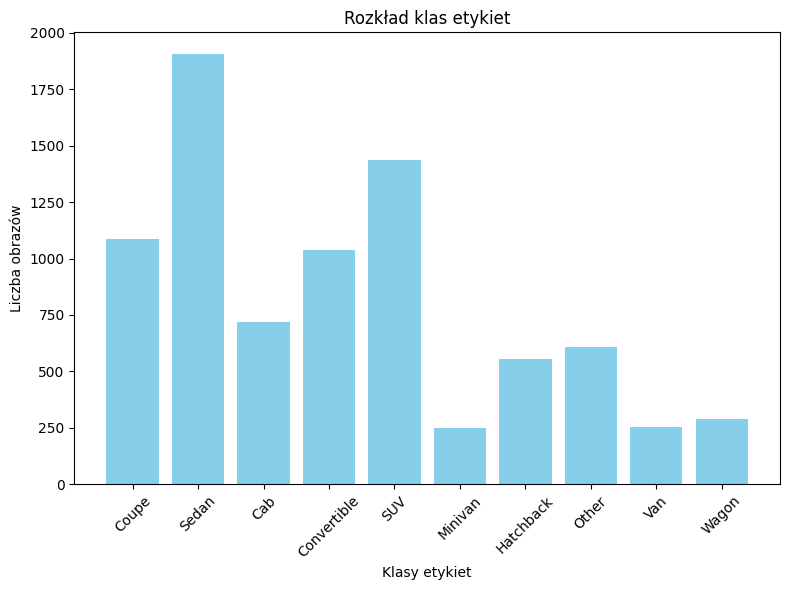

In [5]:
# Zliczenie etykiet
label_counts = Counter(labels_string)

print(label_counts)

# Rozpakowanie nazw etykiet i ich liczności do wykresu słupkowego
labels, counts = zip(*label_counts.items())

# Generowanie wykresu słupkowego
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Klasy etykiet')
plt.ylabel('Liczba obrazów')
plt.title('Rozkład klas etykiet')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

TypeError: Image data of dtype object cannot be converted to float

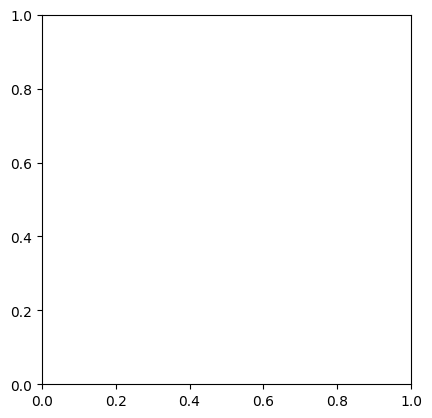

In [19]:
# Indeks obrazu do wyświetlenia
index_to_display = 2137  # Możesz zmienić indeks, aby wyświetlić inny obraz

# Wyświetlenie wybranego obrazu
plt.imshow(images[index_to_display], cmap='gray')  # 'gray' oznacza, że obraz będzie wyświetlony w skali szarości
plt.axis('off')  # Wyłączenie osi
plt.title(f"Obraz {index_to_display}")
plt.show()

images len =  8144


ValueError: cannot reshape array of size 4096 into shape (255,255)

In [8]:


X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=1, stratify=labels_encoded)
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

(6515, 255, 255)
(6515, 255, 255, 1)


Epoch 1/5
204/204 [==============================] - 149s 724ms/step - loss: 3.2879 - accuracy: 0.2203 - val_loss: 2.0593 - val_accuracy: 0.2370
Epoch 2/5
204/204 [==============================] - 150s 734ms/step - loss: 1.6322 - accuracy: 0.4573 - val_loss: 2.0468 - val_accuracy: 0.2713
Epoch 3/5
204/204 [==============================] - 149s 733ms/step - loss: 0.8466 - accuracy: 0.7566 - val_loss: 2.2884 - val_accuracy: 0.2664
Epoch 4/5
204/204 [==============================] - 148s 725ms/step - loss: 0.2544 - accuracy: 0.9558 - val_loss: 2.7031 - val_accuracy: 0.2591
Epoch 5/5
204/204 [==============================] - 148s 725ms/step - loss: 0.0717 - accuracy: 0.9954 - val_loss: 3.1928 - val_accuracy: 0.2345


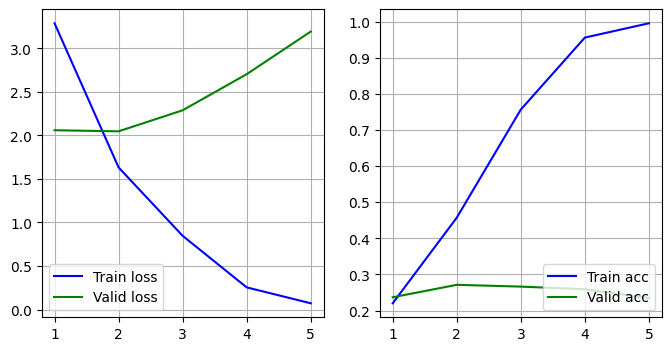

51/51 - 5s - loss: 3.1928 - accuracy: 0.2345 - 5s/epoch - 103ms/step

Test accuracy: 0.23449969291687012


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Skompiluj model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Wytrenuj model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

plotPrint(history)

# Ocena modelu na danych testowych
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

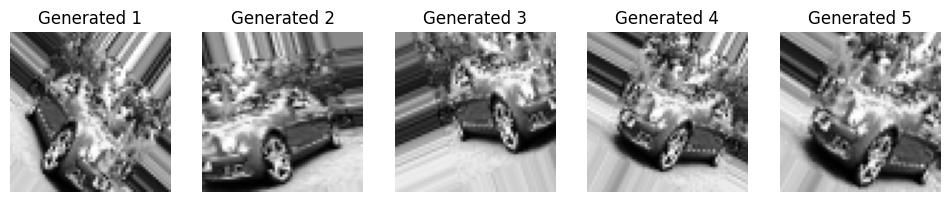

In [69]:
# resizeAndSaveImages('processed','64x64',(64,64))

# chosen_index = 345  # Indeks wybranego zdjęcia
# generate_image_histogram_by_index(images, labels, chosen_index)
# generate_image_histogram_by_index(imagesProc, labels, chosen_index)

datagen = ImageDataGenerator(
    rotation_range=40,      # Zakres kątów rotacji
    width_shift_range=0.2,  # Zakres przesunięcia w poziomie
    height_shift_range=0.2, # Zakres przesunięcia w pionie
    shear_range=0.2,        # Zakres kątów pochylenia
    zoom_range=0.2,         # Zakres powiększania
    horizontal_flip=True,   # Odbicie poziome
    fill_mode='nearest'     # Sposób wypełniania pikseli przy przesunięciu
)

img = X_train[0]
img = np.expand_dims(img, axis=0)  # Dodanie dodatkowego wymiaru
img = img * 255.
flow = datagen.flow(img, batch_size=1)

# Generowanie kilku obrazów za pomocą ImageDataGenerator
generated_images = [next(flow)[0].astype(np.uint8).reshape(X_train[0].shape) for _ in range(5)] 

# Wyświetlenie wygenerowanych obrazów
plt.figure(figsize=(12, 6))
for i, img in enumerate(generated_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Generated {i + 1}')
    plt.axis('off')

plt.show()

Counter({'Sedan': 1907, 'Van': 1513, 'SUV': 1437, 'Coupe': 1088, 'Convertible': 1036})


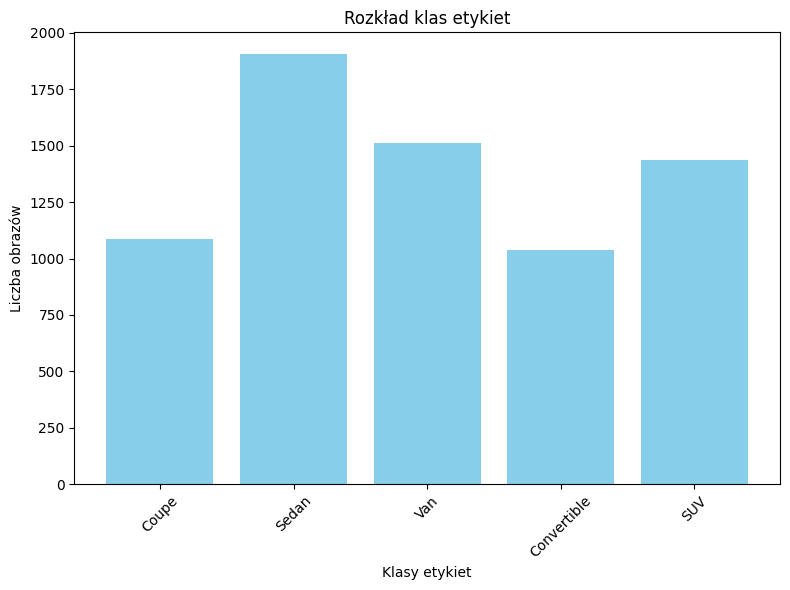

(6981,)
(6981,)


ValueError: Found input variables with inconsistent numbers of samples: [0, 6981]

In [18]:
images, labels = loadImage('128x128')

labelsPlot(labels)
labels, encoder = encodeLabel(labels)
print(labels.shape)
print(images.shape)
imagesProc = preprocessImages(images)
X_train, X_test, y_train, y_test = splitData(imagesProc,labels)

Epoch 1/5
204/204 [==============================] - 7s 32ms/step - loss: 2.1056 - accuracy: 0.2318 - val_loss: 2.0834 - val_accuracy: 0.2327
Epoch 2/5
204/204 [==============================] - 6s 31ms/step - loss: 2.0381 - accuracy: 0.2568 - val_loss: 2.0576 - val_accuracy: 0.2290
Epoch 3/5
204/204 [==============================] - 6s 31ms/step - loss: 1.9693 - accuracy: 0.2899 - val_loss: 2.0424 - val_accuracy: 0.2572
Epoch 4/5
204/204 [==============================] - 6s 30ms/step - loss: 1.8926 - accuracy: 0.3216 - val_loss: 2.0354 - val_accuracy: 0.2689
Epoch 5/5
204/204 [==============================] - 6s 31ms/step - loss: 1.8127 - accuracy: 0.3513 - val_loss: 2.0077 - val_accuracy: 0.2738


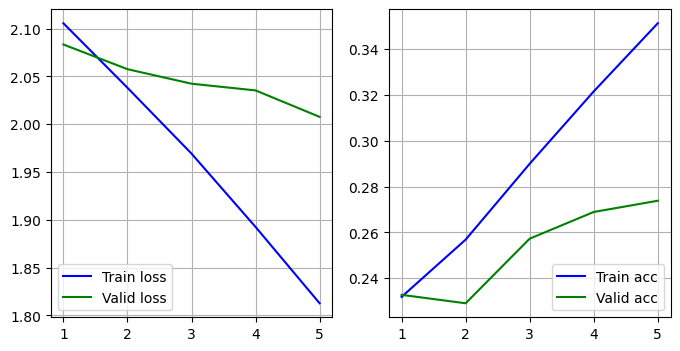

51/51 - 0s - loss: 2.0077 - accuracy: 0.2738 - 422ms/epoch - 8ms/step

Test accuracy: 0.27378758788108826


In [55]:
input_shape = X_train.shape[1:]
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  # Dodanie warstwy dropout
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Skompiluj model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Wytrenuj model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

plotPrint(history)

# Ocena modelu na danych testowych
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

C:\Users\Cezary\AppData\Local\Temp\ipykernel_7712\1498477278.py:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
203/203 [==============================] - 23s 107ms/step - loss: 2.1108 - accuracy: 0.2283 - val_loss: 2.1198 - val_accuracy: 0.2339
Epoch 2/5
203/203 [==============================] - 22s 109ms/step - loss: 2.0877 - accuracy: 0.2329 - val_loss: 2.0829 - val_accuracy: 0.2253
Epoch 3/5
203/203 [==============================] - 22s 107ms/step - loss: 2.0708 - accuracy: 0.2422 - val_loss: 2.1400 - val_accuracy: 0.2284
Epoch 4/5
203/203 [==============================] - 22s 109ms/step - loss: 2.0511 - accuracy: 0.2508 - val_loss: 2.0531 - val_accuracy: 0.2376
Epoch 5/5
203/203 [==============================] - 22s 106ms/step - loss: 2.0371 - accuracy: 0.2641 - val_loss: 2.0252 - val_accuracy: 0.2603


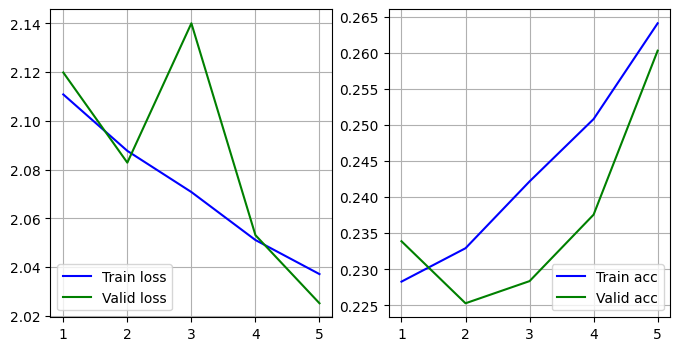

51/51 - 1s - loss: 2.0252 - accuracy: 0.2603 - 1s/epoch - 23ms/step

Test accuracy: 0.26028236746788025


In [9]:
label_encoder = encoder 
input_shape = X_train.shape[1:]
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  # Dodanie warstwy dropout
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Skompiluj model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Tworzenie instancji ImageDataGenerator do augmentacji danych treningowych
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0.5
)

# Ustawienie generatora dla danych treningowych
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Ustawienie callbacku do zapisywania modelu
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{modelsDir}model.h5', save_best_only=True)

# Trenowanie modelu z użyciem generatora
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train) // 32,  # Liczba kroków na epokę (długość danych treningowych / batch_size)
    epochs=5,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]
)


plotPrint(history)

# Ocena modelu na danych testowych
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

In [6]:
generateFromOriginalImages('128x128',(128,128))

   Unnamed: 0  file_name  car_code                             car_name  \
0           0  00001.jpg        14                  Audi TTS Coupe 2012   
1           1  00002.jpg         3                  Acura TL Sedan 2012   
2           2  00003.jpg        91           Dodge Dakota Club Cab 2007   
3           3  00004.jpg       134     Hyundai Sonata Hybrid Sedan 2012   
4           4  00005.jpg       106  Ford F-450 Super Duty Crew Cab 2012   

     brand car_type                                   new_filename  
0     Audi    Coupe                  00001_Audi TTS Coupe 2012.jpg  
1    Acura    Sedan                  00002_Acura TL Sedan 2012.jpg  
2    Dodge      Cab           00003_Dodge Dakota Club Cab 2007.jpg  
3  Hyundai    Sedan     00004_Hyundai Sonata Hybrid Sedan 2012.jpg  
4     Ford      Cab  00005_Ford F-450 Super Duty Crew Cab 2012.jpg  
Counter({'Sedan': 1907, 'SUV': 1437, 'Coupe': 1088, 'Convertible': 1036, 'Cab': 719, 'Other': 609, 'Hatchback': 554, 'Wagon': 291, 'Van

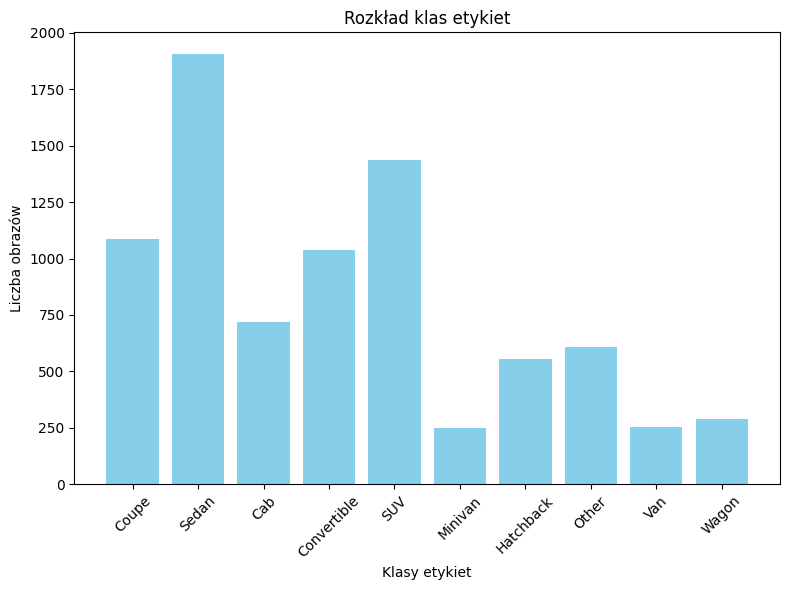

Counter({'Sedan': 1907, 'Van': 1513, 'SUV': 1437, 'Coupe': 1088, 'Convertible': 1036})


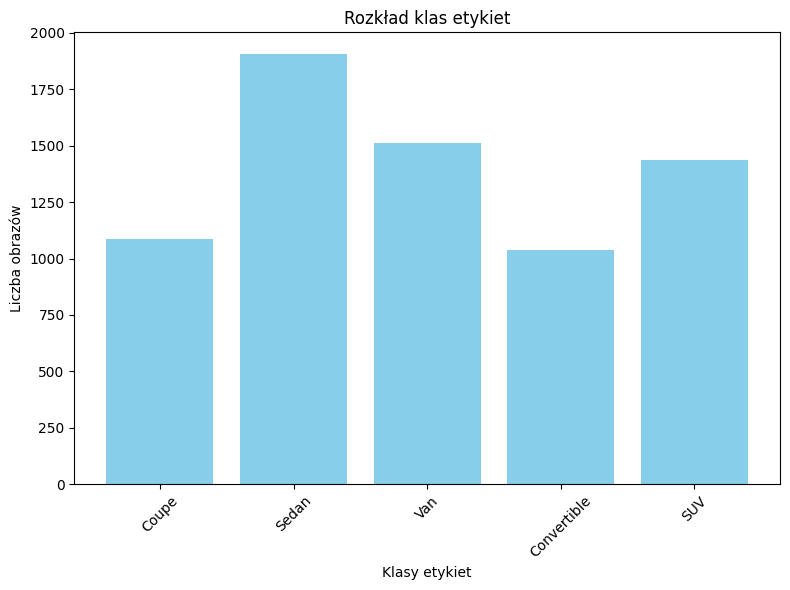

In [8]:
csv_file = 'data/stanford_cars_type.csv'
data_csv = pd.read_csv(csv_file)
print(data_csv.head())
labelsPlot(data_csv['car_type'])
data_csv['car_type'].replace('Minivan', 'Van', inplace=True)

data_csv['car_type'].replace('Wagon', 'Van', inplace=True)

data_csv['car_type'].replace('Cab', 'Van', inplace=True)

data_csv = data_csv[~data_csv['car_type'].isin(['Other', 'Hatchback'])]

labelsPlot(data_csv['car_type'])

data_csv.to_csv('data/new_stanford_cars_type.csv', index=False)